[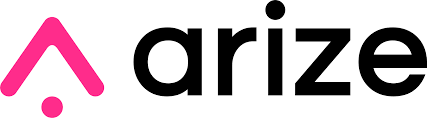](https://arize.com)

# Optimizing JSON Webpage Prompts with the Arize Prompt Learning SDK

In this cookbook, we demonstrate a use case of the Arize Prompt Learning SDK by optimizing a system prompt for GPT-4o. The goal is to improve the model’s ability to generate accurate JSON representations of webpages in response to user queries. The dataset consists of prompts asking GPT to generate webpages, and we define 10 specific rules that the JSON outputs must satisfy. Using the SDK, we iteratively refine the prompt to achieve high accuracy on the training set, and then evaluate its performance on a separate test set.

In [ ]:
!pip install arize-phoenix-evals arize-phoenix-client tiktoken openai arize-toolkit==1.0.5 scikit-learn

## Configuration

NUM_SAMPLES: Controls how many rows to sample from the full dataset. Set to 0 to use all available data, or a positive number to limit the sample size for faster experimentation.

TRAIN_SPLIT_FRACTION: Determines the train/test split ratio. 0.8 means 80% of data goes to training set, 20% to test set.

NUM_RULES: Specifies the number of rules to use for evaluation. This determines which prompt files to load (e.g., evaluator-prompt-10.txt vs evaluator-prompt-50.txt).

NUM_OPTIMIZATION_LOOPS: Sets how many optimization iterations to run per experiment. Each loop generates outputs, evaluates them, and refines the prompt.

These variables control the experiment scope, data splitting, evaluation criteria, and optimization intensity.

In [25]:
# CONFIG: Number of samples to use for the experiment. Adjust as needed.
NUM_SAMPLES = 50  # Number of rows to sample from the full dataset, 0 for all
TRAIN_SPLIT_FRACTION = 0.5  # Fraction of data to use for training (rest for testing)
NUM_RULES = 50  # Number of rules in the prompt - adjust based on your evaluator prompt (this is NOT working on Config)
NUM_OPTIMIZATION_LOOPS = 2  # Number of optimization loops per experiment

Run the following cell. It simply monkey patches one of our Phoenix methods for this notebook to work.

In [3]:
import nest_asyncio, re
nest_asyncio.apply()

# 1️⃣  stricter variable detector
from phoenix.evals.templates import PromptTemplate, PromptPartTemplate
_TEMPLATE_RE = re.compile(r"\{([a-zA-Z_][a-zA-Z0-9_]*)\}")
def _parse_variables_strict(self, tmpl: list[PromptPartTemplate]):  # [...]
    vars = set()
    for p in tmpl:
        vars.update(m.group(1) for m in _TEMPLATE_RE.finditer(p.template))
    return list(vars)
PromptTemplate._parse_variables = _parse_variables_strict

# 2️⃣  literal‑brace formatter
from phoenix.evals.templates import PromptPart, MultimodalPrompt
def _format_literal(self, variable_values, options=None):  # [...]
    prompt_msgs = []
    for part in self.prompt(options):
        msg = part.template
        for var in self.variables:
            msg = msg.replace(f"{{{var}}}", str(variable_values[var]))
        prompt_msgs.append(PromptPart(content_type=part.content_type, content=msg))
    return MultimodalPrompt(parts=prompt_msgs)
PromptTemplate.format = _format_literal

/Users/priyanjindal/Prompt-Learning/.conda/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## OpenAI Key
We will be using OpenAI to generate the webpage jsons.

In [4]:
import os, getpass
import openai
os.environ['OPENAI_API_KEY'] = getpass.getpass('OpenAI API Key:')
client = openai.Client(api_key=os.getenv("OPENAI_API_KEY"))

## Training and Test Datasets

Create training and test datasets, and export to Arize. 

In [1]:
import pandas as pd

dataset_1000 = pd.read_csv("https://storage.googleapis.com/arize-assets/dev-rel/prompt-learning/queries.csv")
dataset_sample = dataset_1000.sample(NUM_SAMPLES) # 100 rows

# 80-20 split
train_set = dataset_sample.sample(frac=TRAIN_SPLIT_FRACTION, random_state=42)
test_set = dataset_sample.drop(train_set.index)

train_set.to_csv("train.csv", index=False)
test_set.to_csv("test.csv", index=False)

NameError: name 'NUM_SAMPLES' is not defined

## Initial System Prompt

Initialize your system prompt. This is the original prompt that will be tested and optimized.

In [7]:
system_prompt = "You are an expert in JSON webpage creation. This is your task: {input}"

## Evaluators

This cell initializes two evaluators that use LLMs as judges to assess the quality of generated outputs.

**`evaluate_output`**: A comprehensive evaluator that assesses JSON webpage correctness against the input query and evaluation rules. It provides:
- **Correctness labels**: "correct" or "incorrect" 
- **Detailed explanations**: Reasoning for the evaluation decision

**`rule_checker`**: A specialized evaluator that performs granular rule-by-rule analysis. It:
- **Checks individual rules**: Examines each rule compliance separately

Both evaluators generate feedback that the optimization loop uses to iteratively improve the system prompt. The explanations and rule violations guide the MetaPromptOptimizer in creating more effective prompts.

In [21]:
import re
import json
from phoenix.evals import OpenAIModel, llm_generate
import nest_asyncio
nest_asyncio.apply()

def find_correctness(output):
    """Extract correctness from LLM output"""
    # Look for "correct" or "incorrect" in the response
    pattern = r'"correctness":\s*"?(correct|incorrect)"?'
    match = re.search(pattern, output, re.IGNORECASE)
    if match:
        return match.group(1).lower()
    else:
        return None

def find_explanation(output):
    """Extract explanation from LLM output"""
    # Look for explanation field in JSON
    pattern = r'"explanation":\s*"([^"]*)"'
    match = re.search(pattern, output, re.IGNORECASE)
    if match:
        return match.group(1)
    else:
        return None

def evaluate_output_parser(response: str, row_index: int) -> dict:
    """Parser function for evaluate_output evaluator"""
    correctness = find_correctness(response)
    explanation = find_explanation(response)
    
    return {
        "correctness": correctness,
        "explanation": explanation
    }

def rule_checker_parser(response: str, row_index: int) -> dict:
    """Parser function for rule_checker evaluator"""
    explanation = find_explanation(response)
    
    return {
        "rule_violations": explanation
    }

def evaluate_output(dataset):
    """Evaluator that checks JSON web page correctness using llm_generate"""
    
    # Create the evaluation template
    
    with open(f"../prompts/evaluator-prompt-{NUM_RULES}.txt", "r") as file:
        evaluation_template = file.read()

    # Create the model
    eval_model = OpenAIModel(
        model="gpt-4.1-2025-04-14",
        model_kwargs={
            "response_format": {"type": "json_object"},
            "temperature": 0
        }
    )

    # Generate evaluations using llm_generate
    evaluation_results = llm_generate(
        dataframe=dataset,
        template=evaluation_template,
        model=eval_model,
        output_parser=evaluate_output_parser,
        concurrency=40,
        verbose=True
    )

    # Merge the results back into the original dataset
    dataset = dataset.copy()
    for col in ["correctness", "explanation"]:
        if col in evaluation_results.columns:
            dataset[col] = evaluation_results[col]

    return dataset, ["correctness", "explanation"]

def rule_checker(dataset):
    """Evaluator that checks which rules are broken using llm_generate"""
    
    # Create the rule checking template
    with open(f"../prompts/rule-checker-prompt-{NUM_RULES}.txt", "r") as file:
        rule_check_template = file.read()

    # Create the model
    eval_model = OpenAIModel(
        model_name="gpt-4.1-2025-04-14",
        model_kwargs={
            "response_format": {"type": "json_object"},
            "temperature": 0
        }
    )

    # Generate rule checks using llm_generate
    rule_check_results = llm_generate(
        dataframe=dataset,
        template=rule_check_template,
        model=eval_model,
        output_parser=rule_checker_parser,
        concurrency=40,
        verbose=True
    )

    # Merge the results back into the original dataset
    dataset = dataset.copy()
    if "rule_violations" in rule_check_results.columns:
        dataset["rule_violations"] = rule_check_results["rule_violations"]

    return dataset, ["rule_violations"]

## Output Generation

This cell defines the function that generates JSON webpage outputs using the current system prompt.

**Model**: Uses GPT-4.1 with JSON response format and zero temperature for consistent outputs.

**Function**: Takes a dataset and system prompt, generates outputs for all rows, and returns the results for evaluation.

**Usage**: Called during each optimization iteration to produce outputs that will be evaluated by the assessors.

In [9]:
def generate_output(dataset, system_prompt):
    output_model = OpenAIModel(
        model="gpt-4.1-2025-04-14",
        model_kwargs={
            "response_format": {"type": "json_object"},
            "temperature": 0
        }
    )
    outputs = llm_generate(
        dataframe=dataset,
        template=system_prompt,
        model=output_model,
        concurrency=40,
        verbose=True
    )
    return outputs["output"]
    

# Additional Metrics

In [13]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

def compute_metric(y_true, y_pred, scorer="accuracy"):
    """
    Compute the requested metric for binary classification.
    y_true and y_pred should be lists or arrays of "correct"/"incorrect" labels.
    scorer: one of "accuracy", "f1", "precision", "recall"
    """
    # Map to binary
    y_true_bin = [1 if y == "correct" else 0 for y in y_true]
    y_pred_bin = [1 if y == "correct" else 0 for y in y_pred]
    if scorer == "accuracy":
        return accuracy_score(y_true_bin, y_pred_bin)
    elif scorer == "f1":
        return f1_score(y_true_bin, y_pred_bin, zero_division=0)
    elif scorer == "precision":
        return precision_score(y_true_bin, y_pred_bin, zero_division=0)
    elif scorer == "recall":
        return recall_score(y_true_bin, y_pred_bin, zero_division=0)
    else:
        raise ValueError(f"Unknown scorer: {scorer}")

## Optimization Loop

This cell implements the core prompt optimization algorithm. The loop follows a 3-step process:

**Generate & Evaluate**: Generate outputs using the current prompt on the test dataset and evaluate their correctness  
**Train & Optimize**: If results are unsatisfactory, generate outputs on the training set, evaluate them, and use the feedback to create an improved prompt  
**Iterate**: Repeat until either the threshold is met or all loops are completed

The algorithm tracks metrics across iterations and returns detailed results including train/test accuracy scores, optimized prompts, and raw evaluation data. The optimization uses the MetaPromptOptimizer to iteratively refine the system prompt based on evaluator feedback.

**Key parameters:**
- `threshold`: Target accuracy score to stop optimization
- `loops`: Maximum number of optimization iterations  
- `scorer`: Metric to optimize (accuracy, f1, precision, recall)
- `num_rules`: Number of evaluation rules to use

In [23]:
from arize_toolkit.extensions.prompt_optimizer import MetaPromptOptimizer

def optimize_loop(
    train_set,
    test_set,
    system_prompt,
    evaluators,
    threshold=0.7,
    loops=5,
    scorer="accuracy",
):
    """
    scorer: one of "accuracy", "f1", "precision", "recall"
    threshold: float, threshold for the selected metric

    Returns:
        dict with keys:
            "train": list of train set scores per run
            "test": list of test set scores per run
            "prompt": list of system prompts used for each test run
            "raw": list of test set DataFrames (deepcopy) for each test run
    """
    import copy

    curr_loop = 1
    train_metrics = []
    test_metrics = []
    prompts = []
    raw_dfs = []

    print(f"🚀 Starting prompt optimization with {loops} iterations (scorer: {scorer}, threshold: {threshold})")
    print()
    
    # Initial test evaluation before optimization
    print(f"📊 Initial evaluation:")
    test_set["output"] = generate_output(test_set, system_prompt)
    
    test_evals_all = evaluate_output(test_set)[0]
    test_evals = test_evals_all["correctness"]
    y_true = ["correct"] * len(test_evals)
    y_pred = test_evals
    initial_metric_value = compute_metric(y_true, y_pred, scorer=scorer)
    test_metrics.append(initial_metric_value)
    prompts.append(system_prompt)
    raw_dfs.append(copy.deepcopy(test_set))
    
    print(f"✅ Initial test {scorer}: {initial_metric_value}")
    print('\n')
    
    if initial_metric_value >= threshold:
        print(f"🎉 Initial prompt already meets threshold!")
        result = {
            "train": train_metrics,
            "test": test_metrics,
            "prompt": prompts,
            "raw": raw_dfs,
        }
        return result
    
    while loops > 0:
        print(f"📊 Loop {curr_loop}: Optimizing prompt...")
        
        # 1. Train set evaluation and optimization
        train_outputs = generate_output(train_set, system_prompt)
        train_set["output"] = train_outputs

        train_set["correctness"] = [None] * len(train_set)
        train_set["explanation"] = [None] * len(train_set)
        train_set["rule_violations"] = [None] * len(train_set)

        optimizer = MetaPromptOptimizer(
            prompt=system_prompt,
            model_choice="gpt-4o",
            openai_api_key=os.getenv("OPENAI_API_KEY")
        )
        
        train_set, _ = optimizer.run_evaluators(
            train_set,
            evaluators,
            feedback_columns=["correctness", "explanation", "rule_violations"]
        )

        system_prompt = optimizer.optimize(
            train_set,
            "output",
            feedback_columns=["correctness", "explanation", "rule_violations"],
            context_size_k=128000
        )

        # Evaluate train set after optimization
        train_outputs_post = generate_output(train_set, system_prompt)
        train_set_post = train_set.copy()
        train_set_post["output"] = train_outputs_post
        train_evals_post_all = evaluate_output(train_set_post)[0]
        train_evals_post = train_evals_post_all["correctness"]
        y_true_train_post = ["correct"] * len(train_evals_post)
        y_pred_train_post = train_evals_post
        train_metric_post_value = compute_metric(y_true_train_post, y_pred_train_post, scorer=scorer)
        train_metrics.append(train_metric_post_value)
        print(f"✅ Train {scorer}: {train_metric_post_value}")

        # 2. Test set evaluation with optimized prompt
        test_set["output"] = generate_output(test_set, system_prompt)
        
        test_evals_all = evaluate_output(test_set)[0]
        test_evals = test_evals_all["correctness"]
        y_true = ["correct"] * len(test_evals)
        y_pred = test_evals
        metric_value = compute_metric(y_true, y_pred, scorer=scorer)
        test_metrics.append(metric_value)
        prompts.append(system_prompt)
        raw_dfs.append(copy.deepcopy(test_set))
        
        print(f"✅ Test {scorer}: {metric_value}")
        print("\n")
        
        # 3. Check threshold
        if metric_value >= threshold:
            print(f"🎉 Threshold reached! Stopping optimization.")
            result = {
                "train": train_metrics,
                "test": test_metrics,
                "prompt": prompts,
                "raw": raw_dfs,
            }
            return result

        loops -= 1
        curr_loop += 1

    print(f"🔄 All {curr_loop-1} optimization loops completed.")
    result = {
        "train": train_metrics,
        "test": test_metrics,
        "prompt": prompts,
        "raw": raw_dfs,
    }
    return result

## Results Saving Functions

This cell defines two utility functions for saving experiment results in different formats:

**`save_experiment_results()`**: Saves complete experiment data to JSON format with timestamps. Useful for preserving all experiment details including raw evaluation data and metadata.

**`save_single_experiment_csv()`**: Creates lightweight CSV files with iteration-level data including:
- Iteration number
- Number of rules used
- Test and train accuracy scores  
- Optimized prompt text

The CSV format makes it easy to analyze performance trends and prompt evolution over time. Files are automatically timestamped to avoid overwriting previous results.

**Output format**: Each row represents one optimization iteration with metrics and the corresponding optimized prompt.

In [19]:
import pandas as pd
import json
from datetime import datetime


def save_experiment_results(results, filename="experiment_results.json"):
    """Save experiment results to a JSON file."""
    
    # Add timestamp to results
    results_with_timestamp = {
        "timestamp": datetime.now().isoformat(),
        "results": results
    }
    
    with open(filename, 'w') as f:
        json.dump(results_with_timestamp, f, indent=2, default=str)
    
    print(f"✅ Results saved to {filename}")

def save_single_experiment_csv(results, filename):
    """
    Save a single experiment's results to CSV format.
    
    Args:
        results: Results from a single optimize_loop run
        filename: Output CSV filename
    """
    
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    
    # Extract data
    train_metrics = results.get('train', [])
    test_metrics = results['test']
    prompts = results['prompt']
    
    # Create DataFrame
    data = []
    for i, (test_metric, prompt) in enumerate(zip(test_metrics, prompts)):
        row = {
            'iteration': i,
            'test_accuracy': test_metric,
            'prompt': prompt
        }
        
        # Add train metric if available
        if i < len(train_metrics):
            row['train_accuracy'] = train_metrics[i]
        
        data.append(row)
    
    df = pd.DataFrame(data)
    
    # Save to CSV with timestamp
    filename_with_timestamp = f"{filename}_{timestamp}.csv"
    df.to_csv(filename_with_timestamp, index=False)
    print(f"✅ Results saved to {filename_with_timestamp}")
    print(f"   📊 {len(df)} iterations")
    print(f"   📈 Final accuracy: {df['test_accuracy'].iloc[-1]:.3f}")

## Experiment Execution

This cell runs a prompt optimization experiment and saves the results.

**Execution**: Runs the optimization loop with the specified evaluators and configuration parameters, tracking performance across iterations.

**Results Saving**: 
- **JSON format**: Saves complete experiment data with timestamps for detailed analysis
- **CSV format**: Creates lightweight CSV files with iteration data, metrics, and prompts for easy visualization

The CSV output includes columns for iteration number, number of rules, test/train accuracy scores, and the optimized prompt text, making it easy to analyze performance trends and prompt evolution over time.

**Output files**: 
- `experiment_results.json` - Complete experiment data
- `experiment_YYYYMMDD_HHMMSS.csv` - Timestamped CSV with iteration metrics

In [ ]:
evaluators = [evaluate_output, rule_checker]
results = optimize_loop(
    train_set, test_set, system_prompt, evaluators,
    loops=NUM_OPTIMIZATION_LOOPS
)

# Save results
save_experiment_results(results, "experiment_results.json")

# Save CSV results
save_single_experiment_csv(results, "experiment")

print("\n📊 Experiment results:")
print(results)

🚀 Starting prompt optimization with 2 iterations (scorer: accuracy, threshold: 0.7)

📊 Initial evaluation:


llm_generate |          | 0/1 (0.0%) | ⏳ 00:04<? | ?it/s 

Process was interrupted. The return value will be incomplete...


llm_generate |          | 0/1 (0.0%) | ⏳ 00:06<? | ?it/s
llm_generate |██████████| 1/1 (100.0%) | ⏳ 00:02<00:00 |  2.53s/it


✅ Initial test accuracy: 0.0


📊 Loop 1: Optimizing prompt...


llm_generate |██▌       | 1/4 (25.0%) | ⏳ 00:07<00:21 |  7.05s/it

## Now you have your optimized system prompt!

Here is the prompt that achieved the best test accuracy across the optimization iterations.

In [ ]:
def get_best_prompt(results):
    """
    Extract the prompt that achieved the best test accuracy.
    
    Args:
        results: Results from optimize_loop or experiment
        
    Returns:
        tuple: (best_prompt, best_accuracy, iteration_number)
    """
    test_metrics = results['test']
    prompts = results['prompt']
    
    # Find the iteration with highest test accuracy
    best_iteration = test_metrics.index(max(test_metrics))
    best_accuracy = test_metrics[best_iteration]
    best_prompt = prompts[best_iteration]
    
    return best_prompt, best_accuracy, best_iteration

# Usage example:
best_prompt, best_accuracy, best_iter = get_best_prompt(results)
print(f"Best prompt (iteration {best_iter}, accuracy: {best_accuracy:.3f}):")
print(best_prompt)